In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.linalg import inv
from scipy.stats import norm
from scipy.optimize import minimize
from filterpy.kalman import KalmanFilter
from statsmodels.tsa.arima.model import ARIMA

Helper Functions

In [3]:
def moving_average(series, m=12):
        '''Compute the length-m moving average of a series
        '''
        if len(series) < m:
            raise ValueError("Window size cannot be larger than the array length.")
        ret = np.cumsum(series, dtype=float)
        ret[m:] = ret[m:] - ret[:-m]
        return ret[m - 1:] / m

def detrend(time_series):
    '''Compute the detrended, covariance stationary version of a time series containing 
       housing price data for a single region using a moving average.
        Parameters:
            time_series (ndarray) : the original time series
        Returns:
            (ndarray) : the detrended time series 
    '''
    ma = moving_average(time_series, m=12)
    return time_series[6:-5] - ma

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 # hardcoded for 1d time_series

    F = np.zeros((dim_states, dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0, :len(phis)] = phis
    F[1:, :-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F, F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states, dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def filter(f, zs):
    n = np.size(zs, 0)

    xhat = np.zeros((n, f.dim_x))
    Ps = np.zeros((n, f.dim_x, f.dim_x))

    for i, z in enumerate(zs):
        f.predict()
        f.update(z)
        # print(f.x.copy())
        xhat[i] = f.x.copy()
        Ps[i] = f.P.copy()

    return xhat, Ps

In [4]:
def arma_likelihood(z, phis=np.array([0.9]), thetas=np.array([0]), mu=200000., std=50000):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """

    # construct matrices for state-space model
    n = len(z)
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # print(dim_states, dim_time_series)

    # initialize Kalman Filter
    kf = KalmanFilter(dim_x=dim_states, dim_z=dim_time_series)
    kf.F = F
    #kf.G = np.zeros(1)
    kf.Q = Q
    kf.H = H
    kf.R = np.eye(dim_time_series)

    # P0 = np.linalg.solve(np.eye(dim_states**2) - np.kron(F, F), 
    #         np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states, dim_states))
    P0 = np.eye(dim_states)
    x0 = np.zeros((dim_states,))

    kf.x = x0
    kf.P = P0

    x_hat, P = filter(kf, z - mu)
    # print(P.shape)
    x_hat = x_hat.reshape(n, dim_states)
    P = P.reshape(n, dim_states, dim_states)
    



    # # use the Kalman filter to estimate means and covars
    # x_hat, P = kalman(F, Q, H, z - mu)

    # compute the log-likelihood using Equation 24.18
    log_like = np.sum([norm.logpdf(z[t], loc=(H @ x_hat[t] + mu), scale=np.sqrt(H @ P[t] @ H.T))for t in range(len(z))])

    # print(log_like)
    return log_like

In [5]:
df = pd.read_csv("Data_Files/price_by_state_cleaned.csv")
t_vals = df["Unnamed: 0"].values
time_series = df["Idaho"].values
# z = detrend(time_series)
z = time_series
n = len(z)

arma_likelihood(z)

-276.60049843832684

In [6]:
def model_identification(region_id, region_type, p_min=1, p_max=4, q_min=1, q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    pairs = [(p, q) for p in range(p_min, p_max+1) for q in range(p_min, q_max+1)]
    AICs = np.empty(len(pairs))

    # read in appropriate time series and detrend
    if region_type == "state":
        df = pd.read_csv("Data_Files/price_by_state_cleaned.csv")
    elif region_type == "county":
        df = pd.read_csv("Data_Files/price_by_county_cleaned.csv")
    else:
        raise ValueError("Invalid region type")
    
    # t_vals = df["Unnamed: 0"].values
    time_series = df[region_id].values
    z = detrend(time_series)
    # z = time_series
    n = len(z)
    sols = []

    for i, pair in enumerate(pairs):
        p, q = pair
        def f(x):
            try:
                return -1*arma_likelihood(z, phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])
            except np.linalg.LinAlgError:
                return np.inf
        
        k = p + q + 2
        # create initial point
        x0 = np.ones(k)
        x0[-2] = z.mean()
        x0[-1] = z.std()

        # maximize the log-likelihood
        sol = minimize(f, x0, method="SLSQP")
        sol = sol['x']
        sols.append(sol)
        log_like = arma_likelihood(z, phis=sol[:p], thetas=sol[p:p+q], mu=sol[-2], std=sol[-1])

        # compute the aic
        aic = 2*k*(1 + (k + 1)/(n - k)) - 2*log_like
        AICs[i] = aic
    
    # find the best set of parameters (minimal AIC)
    best_idx = np.argmin(AICs)
    best_params = sols[best_idx]
    p, q = pairs[best_idx]

    return best_params[:p], best_params[p:p+q], best_params[-2], best_params[-1]

In [7]:
phis, thetas, mu, std = model_identification("Arizona", "state", p_min=2, p_max=6, q_min=2, q_max=6)
print(phis, thetas, mu, std)

[1. 1.] [1. 1.] 524.4555026880972 3083.5774598850967


In [10]:
def arma_forecast(region_id, region_type, phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # read in appropriate time series and detrendf
    if region_type == "state":
        df = pd.read_csv("Data_Files/price_by_state_cleaned.csv")
    elif region_type == "county":
        df = pd.read_csv("Data_Files/price_by_county_cleaned.csv")
    else:
        raise ValueError("Invalid region type")
    
    t_vals = df["Unnamed: 0"].values
    time_series = df[region_id].values
    z = detrend(time_series)
    # z = time_series
    k = len(z)
    sols = []
    print(z.shape)

    # represent time series as a state space model
    F, Q, H, dim_states, dim_time_series = state_space_rep(phis, thetas, mu, std)

    # use the kalman filter to estimate hidden states and variances
    x_hat, P = kalman(F, Q, H, z - mu)

    # update step on last element of z_k
    K = P[-1] @ H.T @ inv(H @ P[-1] @ H.T)
    xk_new = x_hat[-1] + K @ (z[-1] - mu - H @ x_hat[-1])
    KH = K @ H
    Pk = (np.eye(len(KH)) - KH) @ P[-1]
    x_hat = np.vstack((x_hat, np.empty((n, x_hat.shape[1]))))
    x_hat[k-1] = xk_new


    # forecast kalman states and observations
    z = np.hstack((z, np.empty(n)))
    low_bound = np.empty(n)
    high_bound = np.empty(n)
    for t in range(k, k+n):
        # predict step of Kalman
        x_hat[t] = F @ x_hat[t-1]
        Pk = F @ Pk @ F.T + Q

        # compute observation and confidence interval
        mean = H @ x_hat[t] + mu
        var = H @ Pk @ H.T
        z[t] = mean 
        low_bound[t-k] = mean - 2*np.sqrt(var)
        high_bound[t-k] = mean + 2*np.sqrt(var)
        
    # plot results
    # t_vals = np.array([13 + (19+i)/24 for i in range(k+n)])
    t_vals = np.linspace(2020, 2023 + n/12, len(z))

    print(x_hat.shape)
    print(z.shape)
    print(t_vals.shape)

    fig = plt.figure(figsize=(9, 4))
    plt.plot(t_vals[:k], z[:k], label="Old Data")
    plt.plot(t_vals[k:], z[k:], '--', label="Forecast")
    plt.plot(t_vals[k:], low_bound, 'g', label="95% Confidence Interval")
    plt.plot(t_vals[k:], high_bound, 'g')
    plt.legend()
    plt.xlabel("Day of the Month")
    plt.ylabel(r"Change in Temperature $(C) - \mu = 0$")
    plt.legend()
    plt.title(f"ARMA({len(phis)},{len(thetas)}) Kalman Forecast")
    plt.show()

(290,)
(340, 3)
(340,)
(340,)


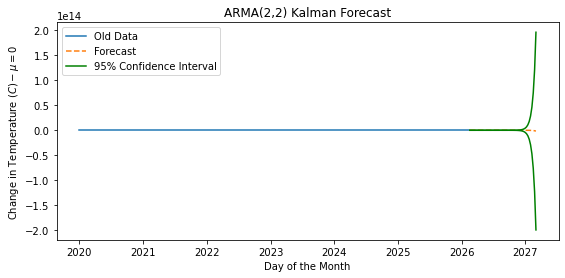

In [11]:
arma_forecast("Arizona", "state", phis, thetas, mu, std, 50)

Try to use SARIMAX model